## Introduction to ML 


#### This tutorial provides a practical introduction to the field of machine learning. It reviews both methodological concepts like supervised and unsupervised learning, but also software libraries such as scikit-learn, pandas, and numpy. 

#### Author: Laurent Charlin <lcharlin@gmail.com>

	Content
	- Load data in 
	- Look at some descriptive stats
	- Run a model 
		- Average performance 
		- Individual output 
			- best/worse
		- Plot some output
			- e.g., training through time. 
		- More complicated model on same data. 
            - 1 hidden-layer neural network.
                a) output: regression
                b) output: half of the ratings. (use an autoencoder? would have to fix observed/unobserved...). 
		- save/load model. 
		- plug-in the result of one model into another. (cluster the tags, use the cluster memberships of each movie.)

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import cluster

In [2]:
DATA_DIR='dat/ml-1m/' 
## Use ML-1M. Comes with user features. It comes with genres (not tags) but we can still cluster them.
## We could use the tags from ML-20M. We just have to match movies (movie IDs match between ML-1M and ML-20M)
## Keep the top N tags (say 100, or based on frequency), cluster these same tags.
# The model is: 
# y_ui = id_u b_u + id_i b_i + zip_u w2 + \sum_i tag_i wi + gender_u w + age_u w 
# notes: don't use movie genre. 
# 

### PRE-process: begin

In [3]:
# MovieID::Name::Genres
movies_pd = pd.read_csv(os.path.join(DATA_DIR, 'movies.dat'), sep='::', 
                       names=['mid', 'mName', 'mGenres'])
print(movies_pd.shape)

(3883, 3)


/Users/lcharlin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
#LOAD
# load ratings (y)
# 1::1193::5::978300760
# UserID:MovieID:Rating:Timestamp
#ratings = np.loadtxt(os.path.join(DATA_DIR, 'ratings.dat'), delimiter='::', skiprows=0, dtype=np.int32)
ratings_pd = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'), sep='::', names=['uid', 'mid', 'rating', 'timestamp'])

/Users/lcharlin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [5]:
print(ratings_pd.shape)
print(ratings_pd.shape)
print(ratings_pd['uid'].nunique())
print(ratings_pd['mid'].nunique())

(1000209, 4)
(1000209, 4)
6040
3706


In [6]:
#LOAD
# load user features (x's, )
#user_features = np.loadtxt(os.path.join(DATA_DIR, 'users.dat'))
#UserID::Gender::Age::Occupation::Zip-code
#users = np.loadtxt(os.path.join(DATA_DIR, 'users.dat'), delimiter='::',
#                       dtype={'names': ('uid', 'gender', 'age', 'occupation', 'zip'),
#                         'formats': ('i4', 'S1', 'i4', 'i1', 'U15')})
users_pd = pd.read_csv(os.path.join(DATA_DIR, 'users.dat'),
                       sep='::',
                       names=['uid', 'gender', 'age', 'occupation', 'zip'])
users_pd['zip'] = users_pd['zip'].apply(lambda x: x[:2])
display(users_pd['zip'].head(10))
# load tags
# load from ML-20M
#tags = np.loadtxt(os.path.join(DATA_DIR, 'ratings.csv'), delimiter='::', skiprows=0)
# Keep only tags for movies in ML-1M
# ...
print(ratings_pd.shape)
print(users_pd.shape)

/Users/lcharlin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


0    48
1    70
2    55
3    02
4    55
5    55
6    06
7    11
8    61
9    95
Name: zip, dtype: object

(1000209, 4)
(6040, 5)


In [7]:
# load ml-20m tags
# movieId,tagId,relevance
tags_scores = pd.read_csv('dat/ml-20m/genome-scores.csv', skiprows=1, names=['mid', 'tid', 'relevance'])
tags_scores.head(10)
print(tags_scores.shape)
# 
tags_names = pd.read_csv('dat/ml-20m/genome-tags.csv', skiprows=1, names=['tid', 'tName'])
tags_names.head(10)


(11709768, 3)


,tid,tName
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
5,6,1950s
6,7,1960s
7,8,1970s
8,9,1980s
9,10,19th century


In [8]:
#!!! I am here: # only keep entries from movies in the ml-1m data.
#tags_scores = tags_scores.loc[:, ratings_pd['mid'].unique()]
tags_scores = tags_scores.loc[tags_scores['mid'].isin(ratings_pd['mid'].unique())]
print(tags_scores.shape)


(3914160, 3)


In [9]:
# Keep only high-relevance tags
print(tags_scores.shape)
print('unique tags:', tags_scores['tid'].nunique())
tags_scores_high = tags_scores.loc[tags_scores['relevance'] > 0.9]
print(tags_scores_high.shape)
print('unique tags w. high relevance:', tags_scores_high['tid'].nunique())

(3914160, 3)
unique tags: 1128
(15766, 3)
unique tags w. high relevance: 968


In [10]:
#pd.merge(users_pd, ratings_pd, how='inner', on='uid')
tags_high_names_movies = pd.merge(tags_scores_high, tags_names, how='inner', on='tid')
tags_high_names_movies = pd.merge(tags_high_names_movies, movies_pd, how='inner', on='mid')
#tags_high_names_movies.mid.nunique()
tags_high_names_movies.head(500)
#tags_high_names_movies.groupby(['mName', 'mGenres', 'mid']).head(50) #groupby(['mName', 'mGenres', 'mid']).head()

,mid,tid,relevance,tName,mName,mGenres
0,1,63,0.93325,animated,Toy Story (1995),Animation|Children's|Comedy
1,1,64,0.98575,animation,Toy Story (1995),Animation|Children's|Comedy
2,1,186,0.95650,cartoon,Toy Story (1995),Animation|Children's|Comedy
3,1,203,0.92625,childhood,Toy Story (1995),Animation|Children's|Comedy
4,1,204,0.96425,children,Toy Story (1995),Animation|Children's|Comedy
5,1,244,0.99850,computer animation,Toy Story (1995),Animation|Children's|Comedy
6,1,310,0.91375,disney animated feature,Toy Story (1995),Animation|Children's|Comedy
7,1,412,0.91175,friendship,Toy Story (1995),Animation|Children's|Comedy
8,1,469,0.92075,great movie,Toy Story (1995),Animation|Children's|Comedy
9,1,536,0.94200,imdb top 250,Toy Story (1995),Animation|Children's|Comedy


In [11]:
print(tags_scores_high.shape)
tags_scores_high_dum = pd.get_dummies(tags_scores_high, columns=['tid'])
#tags_scores_high_dum = tags_scores_high_dum.groupby(['mid']).aggregate(np.sum)
tags_scores_high_dum = tags_scores_high_dum.reset_index()
print(tags_scores_high_dum.shape)

(15766, 3)
(15766, 971)


In [12]:
print(ratings_pd['mid'].nunique())

3706


#### Explore tags

210


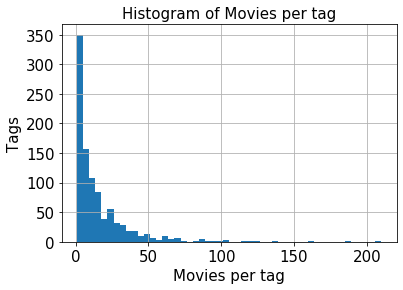

In [13]:
print(tags_scores_high_dum.filter(regex=("tid_*")).aggregate(np.sum).max())
hists = tags_scores_high_dum.filter(regex=("tid_*")).aggregate(np.sum).hist(bins=50, xlabelsize=15, ylabelsize=15)
hists.set_ylabel("Tags", size=15)
hists.set_xlabel("Movies per tag", size=15)
hists.set_title("Histogram of Movies per tag", size=15);
# y-axis: number of tags 
# x-axis: movies per tag

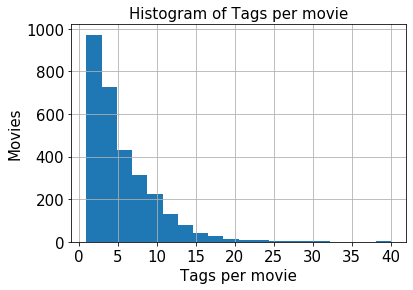

In [14]:
hists = tags_scores_high.groupby("mid").count().hist(bins=20, column="tid", xlabelsize=15, ylabelsize=15)
hists[0][0].set_ylabel("Movies", size=15)
hists[0][0].set_xlabel("Tags per movie", size=15)
hists[0][0].set_title("Histogram of Tags per movie", size=15);
# y-axis: number of movies 
# x-axis: tags per movie

### Cluster tags

In [15]:
n_clusters=100
method = 'KMeans'

# setup data structures
tags_per_movie = tags_scores_high_dum.groupby("mid").sum()

movie_tags_cluster = pd.merge(movies_pd, tags_per_movie, how='inner', on='mid')
x_data = tags_per_movie.filter(regex="(tid_*)").to_numpy(dtype=np.int)


# launch clustering
if method == 'AgglomerativeClustering':
    aggClus = cluster.AgglomerativeClustering(n_clusters=n_clusters, affinity='l2', linkage='average')
    tags_cluster = aggClus.fit_predict(tags_per_movie.filter(regex="(tid_*)").to_numpy(dtype=np.int))

elif method == 'KMeans':
    kmeansClus = cluster.KMeans(n_clusters=n_clusters, precompute_distances='auto')
    tags_cluster = kmeansClus.fit_predict(x_data)

elif method == 'AffinityPropagation':
    apClus = cluster.AffinityPropagation()
    tags_cluster = apClus.fit_predict(x_data)
    # AP automatically determines the number of clusters
    n_clusters = np.unique(tags_cluster).size
    print(n_clusters)

else:
    print('unkown option', method)

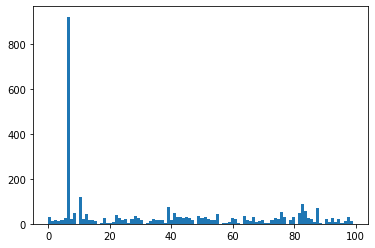

In [16]:
# Histogram of Movies per cluster
pyplot.hist(tags_cluster, bins=n_clusters);

In [17]:
print(tags_cluster[:10])
for i in range(n_clusters):
    idx = np.where(tags_cluster == i)[0]
    print('\nCluster', i, '(number of movies: %d)'% idx.size)
    idx2 = tags_per_movie.iloc[idx].index
    #print(movie_tags_cluster[movie_tags_cluster.mid.isin(idx2)][['mName', 'mGenres']].to_string(index=False))
    display(movie_tags_cluster[movie_tags_cluster.mid.isin(idx2)][['mName', 'mGenres']])

[12 77 42 60 42 30 82 88 84  4]

Cluster 0 (number of movies: 31)


,mName,mGenres
989,April Fool's Day (1986),Comedy|Horror
999,Candyman (1992),Horror
1053,Scream (1996),Horror|Thriller
1204,I Know What You Did Last Summer (1997),Horror|Mystery|Thriller
1428,Freddy's Dead: The Final Nightmare (1991),Horror
1439,Halloween III: Season of the Witch (1983),Horror
1442,Prom Night (1980),Horror
1443,Hello Mary Lou: Prom Night II (1987),Horror
1444,Prom Night III: The Last Kiss (1989),Horror
1445,Prom Night IV: Deliver Us From Evil (1992),Horror



Cluster 1 (number of movies: 11)


,mName,mGenres
12,Balto (1995),Animation|Children's
535,Oliver & Company (1988),Animation|Children's
755,Alice in Wonderland (1951),Animation|Children's|Musical
756,"Fox and the Hound, The (1981)",Animation|Children's
1106,Cats Don't Dance (1997),Animation|Children's|Musical
1523,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical
1525,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
1530,101 Dalmatians (1961),Animation|Children's
1567,All Dogs Go to Heaven (1989),Animation|Children's
2303,Robin Hood (1973),Animation|Children's



Cluster 2 (number of movies: 17)


,mName,mGenres
354,Dazed and Confused (1993),Comedy
924,Better Off Dead... (1985),Comedy
935,Pump Up the Volume (1990),Drama
952,Heathers (1989),Comedy
1359,Can't Hardly Wait (1998),Comedy|Drama|Romance
1423,"Breakfast Club, The (1985)",Comedy|Drama
1575,Weird Science (1985),Comedy
1585,Sixteen Candles (1984),Comedy
1586,Pretty in Pink (1986),Comedy|Drama|Romance
1660,My Bodyguard (1980),Drama



Cluster 3 (number of movies: 14)


,mName,mGenres
118,Apollo 13 (1995),Drama
382,In the Name of the Father (1993),Drama
420,Rudy (1993),Drama
424,Searching for Bobby Fischer (1993),Drama
1244,Amistad (1997),Drama
1817,Patch Adams (1998),Comedy|Drama
1873,October Sky (1999),Drama
2274,Music of the Heart (1999),Drama
2280,"Insider, The (1999)",Drama
2332,Stand and Deliver (1987),Drama



Cluster 4 (number of movies: 15)


,mName,mGenres
9,GoldenEye (1995),Action|Adventure|Thriller
1256,Tomorrow Never Dies (1997),Action|Romance|Thriller
1766,"View to a Kill, A (1985)",Action
2234,Goldfinger (1964),Action
2235,From Russia with Love (1963),Action
2236,Dr. No (1962),Action
2267,For Your Eyes Only (1981),Action
2268,Licence to Kill (1989),Action
2269,Live and Let Die (1973),Action
2271,Thunderball (1965),Action



Cluster 5 (number of movies: 24)


,mName,mGenres
47,Pocahontas (1995),Animation|Children's|Musical|Romance
295,"Lion King, The (1994)",Animation|Children's|Musical
467,Aladdin (1992),Animation|Children's|Comedy|Musical
472,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
473,Beauty and the Beast (1991),Animation|Children's|Musical
474,Pinocchio (1940),Animation|Children's
487,"Aristocats, The (1970)",Animation|Children's
745,Cinderella (1950),Animation|Children's|Musical
747,"Three Caballeros, The (1945)",Animation|Children's|Musical
748,"Sword in the Stone, The (1963)",Animation|Children's



Cluster 6 (number of movies: 920)


,mName,mGenres
17,Four Rooms (1995),Thriller
20,Get Shorty (1995),Action|Comedy|Drama
23,Powder (1995),Drama|Sci-Fi
30,Dangerous Minds (1995),Drama
33,Babe (1995),Children's|Comedy|Drama
36,Across the Sea of Time (1995),Documentary
37,It Takes Two (1995),Comedy
42,Restoration (1995),Drama
44,To Die For (1995),Comedy|Drama
48,When Night Is Falling (1995),Drama|Romance



Cluster 7 (number of movies: 23)


,mName,mGenres
31,Twelve Monkeys (1995),Drama|Sci-Fi
139,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller
160,Strange Days (1995),Action|Crime|Sci-Fi
167,Waterworld (1995),Action|Adventure
309,Timecop (1994),Action|Sci-Fi
434,Blade Runner (1982),Film-Noir|Sci-Fi
759,"Lawnmower Man, The (1992)",Action|Sci-Fi|Thriller
826,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
1129,"Fifth Element, The (1997)",Action|Sci-Fi
1211,Gattaca (1997),Drama|Sci-Fi|Thriller



Cluster 8 (number of movies: 48)


,mName,mGenres
16,Sense and Sensibility (1995),Drama|Romance
27,Persuasion (1995),Romance
67,"Mis�rables, Les (1995)",Drama|Musical
184,Dolores Claiborne (1994),Drama|Thriller
204,Interview with the Vampire (1994),Drama|Horror
211,Little Women (1994),Drama
223,Mary Shelley's Frankenstein (1994),Drama|Horror
357,Even Cowgirls Get the Blues (1993),Comedy|Romance
429,"Simple Twist of Fate, A (1994)",Drama
486,Jane Eyre (1996),Drama|Romance



Cluster 9 (number of movies: 1)


,mName,mGenres
95,Braveheart (1995),Action|Drama|War



Cluster 10 (number of movies: 121)


,mName,mGenres
63,Friday (1995),Comedy
80,Black Sheep (1996),Comedy
108,Down Periscope (1996),Comedy
145,Mallrats (1995),Comedy
178,Clerks (1994),Comedy
206,"Jerky Boys, The (1994)",Comedy
207,Junior (1994),Comedy|Sci-Fi
217,Major Payne (1994),Comedy
263,National Lampoon's Senior Trip (1995),Comedy
298,"Mask, The (1994)",Comedy|Crime|Fantasy



Cluster 11 (number of movies: 22)


,mName,mGenres
121,Batman Forever (1995),Action|Adventure|Comedy|Crime
140,Judge Dredd (1995),Action|Adventure|Sci-Fi
426,"Shadow, The (1994)",Action
470,Batman (1989),Action|Adventure|Crime|Drama
569,"Phantom, The (1996)",Adventure
1030,Batman Returns (1992),Action|Adventure|Comedy|Crime
1149,Batman & Robin (1997),Action|Adventure|Crime
1167,Spawn (1997),Action|Adventure|Sci-Fi|Thriller
1173,Steel (1997),Action
1489,Condorman (1981),Action|Adventure|Children's|Comedy



Cluster 12 (number of movies: 43)


,mName,mGenres
0,Toy Story (1995),Animation|Children's|Comedy
193,"Goofy Movie, A (1995)",Animation|Children's|Comedy|Romance
252,"Swan Princess, The (1994)",Animation|Children's
443,"Nightmare Before Christmas, The (1993)",Children's|Comedy|Musical
484,Heavy Metal (1981),Action|Adventure|Animation|Horror|Sci-Fi
515,Space Jam (1996),Adventure|Animation|Children's|Comedy|Fantasy
559,"Close Shave, A (1995)",Animation|Comedy|Thriller
746,Winnie the Pooh and the Blustery Day (1968),Animation|Children's
749,So Dear to My Heart (1949),Children's|Drama
753,Pete's Dragon (1977),Adventure|Animation|Children's|Musical



Cluster 13 (number of movies: 19)


,mName,mGenres
146,Mighty Morphin Power Rangers: The Movie (1995),Action|Children's
299,Maverick (1994),Action|Comedy|Western
334,"Beverly Hillbillies, The (1993)",Comedy
464,"Brady Bunch Movie, The (1995)",Comedy
497,Sgt. Bilko (1996),Comedy
665,My Favorite Year (1982),Comedy
1073,McHale's Navy (1997),Comedy|War
1107,Turbo: A Power Rangers Movie (1997),Action|Adventure|Children's
1175,Leave It to Beaver (1997),Comedy
1568,"Addams Family, The (1991)",Comedy



Cluster 14 (number of movies: 18)


,mName,mGenres
131,Desperado (1995),Action|Romance|Thriller
385,Kalifornia (1993),Drama|Thriller
386,Killing Zoe (1994),Thriller
795,Bonnie and Clyde (1967),Crime|Drama
887,"Killer, The (Die xue shuang xiong) (1989)",Action|Thriller
916,Nikita (La Femme Nikita) (1990),Thriller
1261,Jackie Brown (1997),Crime|Drama
1315,Heaven's Burning (1997),Action|Drama
1862,Payback (1999),Action|Thriller
2121,Perfect Blue (1997),Animation|Mystery



Cluster 15 (number of movies: 12)


,mName,mGenres
99,Anne Frank Remembered (1995),Documentary
422,Schindler's List (1993),Drama|War
1247,Bent (1997),Drama|War
1550,Swing Kids (1993),Drama|War
1717,Apt Pupil (1998),Drama|Thriller
1720,Life Is Beautiful (La Vita � bella) (1997),Comedy|Drama
1866,"Last Days, The (1998)",Documentary
2179,Jakob the Liar (1999),Drama
2277,Train of Life (Train De Vie) (1998),Comedy|Drama
2434,"Boys from Brazil, The (1978)",Thriller



Cluster 16 (number of movies: 1)


,mName,mGenres
1910,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller



Cluster 17 (number of movies: 4)


,mName,mGenres
992,"Blob, The (1958)",Horror|Sci-Fi
1655,Cube (1997),Sci-Fi|Thriller
1898,Planet of the Apes (1968),Action|Sci-Fi
2004,Invasion of the Body Snatchers (1956),Horror|Sci-Fi



Cluster 18 (number of movies: 24)


,mName,mGenres
29,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama
216,Legends of the Fall (1994),Drama|Romance|War|Western
539,"Horseman on the Roof, The (Hussard sur le toit...",Drama
813,Microcosmos (Microcosmos: Le peuple de l'herbe...,Documentary
856,"English Patient, The (1996)",Drama|Romance|War
886,Ran (1985),Drama|War
900,Stalker (1979),Mystery|Sci-Fi
947,Raise the Red Lantern (1991),Drama
956,Koyaanisqatsi (1983),Documentary|War
1054,"Last of the Mohicans, The (1992)",Action|Romance|War



Cluster 19 (number of movies: 3)


,mName,mGenres
210,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
866,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
879,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War



Cluster 20 (number of movies: 2)


,mName,mGenres
2794,Mad Max (1979),Action|Sci-Fi
2795,Mad Max 2 (a.k.a. The Road Warrior) (1981),Action|Sci-Fi



Cluster 21 (number of movies: 9)


,mName,mGenres
647,Vertigo (1958),Mystery|Thriller
648,Rear Window (1954),Mystery|Thriller
652,North by Northwest (1959),Drama|Thriller
672,Rebecca (1940),Romance|Thriller
797,Dial M for Murder (1954),Mystery|Thriller
888,Psycho (1960),Horror|Thriller
1037,Jaws (1975),Action|Horror
1624,Strangers on a Train (1951),Film-Noir|Thriller
1638,Shadow of a Doubt (1943),Film-Noir|Thriller



Cluster 22 (number of movies: 41)


,mName,mGenres
289,Forrest Gump (1994),Comedy|Romance|War
471,"Silence of the Lambs, The (1991)",Drama|Thriller
482,Fargo (1996),Crime|Drama|Thriller
621,"Godfather, The (1972)",Action|Crime|Drama
649,It Happened One Night (1934),Comedy
653,"Apartment, The (1960)",Comedy|Drama
670,All About Eve (1950),Drama
812,"Streetcar Named Desire, A (1951)",Drama
864,One Flew Over the Cuckoo's Nest (1975),Drama
874,Lawrence of Arabia (1962),Adventure|War



Cluster 23 (number of movies: 26)


,mName,mGenres
115,Bad Boys (1995),Action
133,Die Hard: With a Vengeance (1995),Action|Thriller
307,Speed (1994),Action|Romance|Thriller
310,True Lies (1994),Action|Adventure|Comedy|Romance
436,Striking Distance (1993),Action
551,"Rock, The (1996)",Action|Adventure|Thriller
607,Chain Reaction (1996),Action|Adventure|Thriller
1023,Die Hard 2 (1990),Action|Thriller
1146,Con Air (1997),Action|Adventure|Thriller
1156,Face/Off (1997),Action|Sci-Fi|Thriller



Cluster 24 (number of movies: 17)


,mName,mGenres
190,French Kiss (1995),Comedy|Romance
203,I.Q. (1994),Comedy|Romance
275,While You Were Sleeping (1995),Comedy|Romance
432,Sleepless in Seattle (1993),Comedy|Romance
475,Pretty Woman (1990),Comedy|Romance
534,"Truth About Cats & Dogs, The (1996)",Comedy|Romance
973,When Harry Met Sally... (1989),Comedy|Romance
1010,"Mirror Has Two Faces, The (1996)",Comedy|Romance
1081,Fools Rush In (1997),Comedy|Romance
1153,My Best Friend's Wedding (1997),Comedy|Romance



Cluster 25 (number of movies: 22)


,mName,mGenres
15,Casino (1995),Drama|Thriller
74,Things to Do in Denver when You're Dead (1995),Crime|Drama|Romance
282,Bullets Over Broadway (1994),Comedy
342,"Bronx Tale, A (1993)",Drama
345,Carlito's Way (1993),Crime|Drama
624,Bound (1996),Crime|Drama|Romance|Thriller
815,"Funeral, The (1996)",Drama
896,Once Upon a Time in America (1984),Crime|Drama|Thriller
912,Miller's Crossing (1990),Drama
1089,Donnie Brasco (1997),Crime|Drama



Cluster 26 (number of movies: 3)


,mName,mGenres
1938,Following (1998),Drama
1946,Open Your Eyes (Abre los ojos) (1997),Drama|Romance|Sci-Fi
2242,Fight Club (1999),Drama



Cluster 27 (number of movies: 22)


,mName,mGenres
643,Singin' in the Rain (1952),Musical|Romance
644,"American in Paris, An (1951)",Musical|Romance
645,Funny Face (1957),Comedy|Musical
651,"Gay Divorcee, The (1934)",Comedy|Musical|Romance
679,"Band Wagon, The (1953)",Comedy|Musical
688,Top Hat (1935),Comedy|Musical|Romance
782,Shall We Dance? (1937),Comedy|Musical|Romance
783,"Damsel in Distress, A (1937)",Comedy|Musical|Romance
860,Strictly Ballroom (1992),Comedy|Romance
1135,Shall We Dance? (Shall We Dansu?) (1996),Comedy



Cluster 28 (number of movies: 34)


,mName,mGenres
24,Leaving Las Vegas (1995),Drama|Romance
96,Taxi Driver (1976),Drama|Thriller
103,Chungking Express (1994),Drama|Mystery|Romance
247,Three Colors: Red (1994),Drama
248,Three Colors: Blue (1993),Drama
397,What Happened Was... (1994),Comedy|Drama|Romance
513,"World of Apu, The (Apur Sansar) (1959)",Drama
567,Ashes of Time (1994),Drama
572,Heavy (1995),Drama|Romance
627,Aiqing wansui (1994),Drama



Cluster 29 (number of movies: 24)


,mName,mGenres
516,Barbarella (1968),Adventure|Sci-Fi
1166,Event Horizon (1997),Action|Mystery|Sci-Fi|Thriller
1314,Lost in Space (1998),Action|Sci-Fi|Thriller
1493,Flight of the Navigator (1986),Adventure|Children's|Sci-Fi
1692,Them! (1954),Sci-Fi|Thriller|War
1710,2010 (1984),Mystery|Sci-Fi
1895,Meteor (1979),Sci-Fi
1937,"Sticky Fingers of Time, The (1997)",Sci-Fi
1961,My Science Project (1985),Adventure|Sci-Fi
1998,Tarantula (1955),Horror|Sci-Fi



Cluster 30 (number of movies: 17)


,mName,mGenres
5,Heat (1995),Action|Crime|Thriller
41,Dead Presidents (1995),Action|Crime|Drama
89,Bottle Rocket (1996),Comedy
814,Palookaville (1996),Action|Drama
1008,Blood & Wine (1997),Drama
1093,City of Industry (1997),Crime|Thriller
1370,Out of Sight (1998),Action|Crime|Romance
1952,Entrapment (1999),Crime|Thriller
2058,"Killing, The (1956)",Crime|Film-Noir
2085,"Thomas Crown Affair, The (1999)",Action|Thriller



Cluster 31 (number of movies: 1)


,mName,mGenres
869,Brazil (1985),Sci-Fi



Cluster 32 (number of movies: 2)


,mName,mGenres
791,Monty Python's Life of Brian (1979),Comedy
831,Monty Python and the Holy Grail (1974),Comedy



Cluster 33 (number of movies: 13)


,mName,mGenres
326,Addams Family Values (1993),Comedy
481,Candyman: Farewell to the Flesh (1995),Horror
1055,"Evening Star, The (1996)",Comedy|Drama
1277,"Prophecy II, The (1998)",Horror
1769,Police Academy 2: Their First Assignment (1985),Comedy
1797,Rocky II (1979),Action|Drama
1808,"Karate Kid, Part II, The (1986)",Action|Adventure|Drama
1884,Pet Sematary II (1992),Horror
1899,Beneath the Planet of the Apes (1970),Action|Sci-Fi
2050,Ghostbusters II (1989),Comedy|Horror



Cluster 34 (number of movies: 21)


,mName,mGenres
101,If Lucy Fell (1996),Comedy|Romance
150,Nine Months (1995),Comedy
290,Four Weddings and a Funeral (1994),Comedy|Romance
292,It Could Happen to You (1994),Drama|Romance
364,For Love or Money (1993),Comedy
498,Jack and Sarah (1995),Romance
523,Mrs. Winterbourne (1996),Comedy|Romance
575,'Til There Was You (1997),Drama|Romance
1169,Picture Perfect (1997),Comedy|Romance
1234,Sliding Doors (1998),Drama|Romance



Cluster 35 (number of movies: 17)


,mName,mGenres
129,Crimson Tide (1995),Drama|Thriller|War
148,Mute Witness (1994),Thriller
283,Clear and Present Danger (1994),Action|Adventure|Thriller
368,"Fugitive, The (1993)",Action|Thriller
381,In the Line of Fire (1993),Action|Thriller
604,Ransom (1996),Drama|Thriller
934,"Manchurian Candidate, The (1962)",Film-Noir|Thriller
1083,Absolute Power (1997),Mystery|Thriller
1180,"Hunt for Red October, The (1990)",Action|Thriller
1193,"Game, The (1997)",Mystery|Thriller



Cluster 36 (number of movies: 15)


,mName,mGenres
116,"Basketball Diaries, The (1995)",Drama
574,Trainspotting (1996),Drama
633,Sweet Nothing (1995),Drama
1075,Gridlock'd (1997),Crime
1349,Fear and Loathing in Las Vegas (1998),Comedy|Drama
1680,Permanent Midnight (1998),Drama
1741,Sid and Nancy (1986),Drama
1824,Another Day in Paradise (1998),Drama
2290,Drugstore Cowboy (1989),Crime|Drama
2484,Bad Lieutenant (1992),Crime|Drama



Cluster 37 (number of movies: 18)


,mName,mGenres
637,Halloween: The Curse of Michael Myers (1995),Horror|Thriller
1004,"Nightmare on Elm Street, A (1984)",Horror
1424,Nightmare on Elm Street Part 2: Freddy's Reven...,Horror
1425,"Nightmare on Elm Street 3: Dream Warriors, A (...",Horror
1426,"Nightmare on Elm Street 4: The Dream Master, A...",Horror
1427,"Nightmare on Elm Street 5: The Dream Child, A ...",Horror
1429,Friday the 13th (1980),Horror
1430,Friday the 13th Part 2 (1981),Horror
1431,Friday the 13th Part 3: 3D (1982),Horror
1432,Friday the 13th: The Final Chapter (1984),Horror



Cluster 38 (number of movies: 2)


,mName,mGenres
870,Aliens (1986),Action|Sci-Fi|Thriller|War
883,Alien (1979),Action|Horror|Sci-Fi|Thriller



Cluster 39 (number of movies: 74)


,mName,mGenres
122,Belle de jour (1967),Drama
171,Before the Rain (Pred dozhdot) (1994),Drama
249,Three Colors: White (1994),Drama
387,King of the Hill (1993),Drama
428,Short Cuts (1993),Drama
507,Purple Noon (1960),Crime|Thriller
512,Pather Panchali (1955),Drama
519,Alphaville (1965),Sci-Fi
520,Clean Slate (Coup de Torchon) (1981),Crime
529,Faces (1968),Drama



Cluster 40 (number of movies: 15)


,mName,mGenres
909,Glory (1989),Action|Drama|War
917,"Bridge on the River Kwai, The (1957)",Drama|War
939,Patton (1970),Drama|War
1479,Saving Private Ryan (1998),Action|Drama|War
2010,"Run Silent, Run Deep (1958)",War
2232,"Dirty Dozen, The (1967)",Action|War
2325,"Longest Day, The (1962)",Action|Drama|War
2328,Tora! Tora! Tora! (1970),War
2527,Cross of Iron (1977),War
2548,"Devil's Brigade, The (1968)",War



Cluster 41 (number of movies: 48)


,mName,mGenres
34,Carrington (1995),Drama|Romance
84,Beautiful Girls (1996),Drama
114,"Brothers McMullen, The (1995)",Comedy
144,Love & Human Remains (1993),Comedy
147,Moonlight and Valentino (1995),Drama|Romance
186,Eat Drink Man Woman (1994),Comedy|Drama
490,My Favorite Season (1993),Drama
522,It's My Party (1995),Drama
577,Stealing Beauty (1996),Drama
591,Walking and Talking (1996),Romance



Cluster 42 (number of movies: 28)


,mName,mGenres
2,Grumpier Old Men (1995),Comedy|Romance
4,Father of the Bride Part II (1995),Comedy
322,Highlander III: The Sorcerer (1994),Action|Sci-Fi
346,City Slickers II: The Legend of Curly's Gold (...,Comedy|Western
598,"Very Brady Sequel, A (1996)",Comedy
610,"Crow: City of Angels, The (1996)",Action|Thriller
734,Herbie Rides Again (1974),Adventure|Children's|Comedy
781,Aladdin and the King of Thieves (1996),Animation|Children's|Comedy
1038,Jaws 2 (1978),Action|Horror
1253,Scream 2 (1997),Horror|Thriller



Cluster 43 (number of movies: 29)


,mName,mGenres
158,Species (1995),Horror|Sci-Fi
255,Stargate (1994),Action|Adventure|Sci-Fi
408,Robert A. Heinlein's The Puppet Masters (1994),Horror|Sci-Fi
562,"Arrival, The (1996)",Action|Sci-Fi|Thriller
576,Independence Day (ID4) (1996),Action|Sci-Fi|War
824,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller
920,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi
979,Alien� (1992),Action|Horror|Sci-Fi|Thriller
1041,Mars Attacks! (1996),Action|Comedy|Sci-Fi|War
1158,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi



Cluster 44 (number of movies: 26)


,mName,mGenres
413,Rising Sun (1993),Action|Drama|Mystery
675,Spellbound (1945),Mystery|Romance|Thriller
685,Laura (1944),Crime|Film-Noir|Mystery
693,"Thin Man, The (1934)",Mystery
784,Crossfire (1947),Crime|Film-Noir
785,"Murder, My Sweet (1944)",Film-Noir|Thriller
837,He Walked by Night (1948),Crime|Film-Noir|Thriller
861,"Thin Blue Line, The (1988)",Documentary
919,Chinatown (1974),Film-Noir|Mystery|Thriller
951,"Big Sleep, The (1946)",Film-Noir|Mystery



Cluster 45 (number of movies: 30)


,mName,mGenres
163,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy
229,Nobody's Fool (1994),Drama
273,What's Eating Gilbert Grape (1993),Drama
565,Gold Diggers: The Secret of Bear Mountain (1995),Adventure|Children's
589,Lone Star (1996),Drama|Mystery
614,"Spitfire Grill, The (1996)",Drama
696,It's a Wonderful Life (1946),Drama
713,Picnic (1955),Drama
737,Pollyanna (1960),Children's|Comedy|Drama
906,Local Hero (1983),Comedy



Cluster 46 (number of movies: 25)


,mName,mGenres
415,Robocop 3 (1993),Sci-Fi|Thriller
494,All Dogs Go to Heaven 2 (1996),Animation|Children's|Musical
1034,Grease 2 (1982),Comedy|Musical|Romance
1039,Jaws 3-D (1983),Action|Horror
1148,Speed 2: Cruise Control (1997),Action|Romance|Thriller
1448,Child's Play 3 (1992),Horror
1451,Poltergeist III (1988),Horror|Thriller
1453,Exorcist II: The Heretic (1977),Horror
1468,"Apple Dumpling Gang Rides Again, The (1979)",Children's|Comedy|Western
1536,Return from Witch Mountain (1978),Children's|Sci-Fi



Cluster 47 (number of movies: 15)


,mName,mGenres
60,Bio-Dome (1996),Comedy
91,Happy Gilmore (1996),Comedy
173,Billy Madison (1995),Comedy
185,Dumb & Dumber (1994),Comedy
271,Tommy Boy (1995),Comedy
278,Ace Ventura: Pet Detective (1994),Comedy
581,Kingpin (1996),Comedy
1067,Beverly Hills Ninja (1997),Action|Comedy
1506,BASEketball (1998),Comedy
1699,"Night at the Roxbury, A (1998)",Comedy



Cluster 48 (number of movies: 1)


,mName,mGenres
1521,Blue Velvet (1986),Drama|Mystery



Cluster 49 (number of movies: 35)


,mName,mGenres
113,"Birdcage, The (1996)",Comedy
138,Jeffrey (1995),Comedy
240,Priest (1994),Drama
260,Strawberry and Chocolate (Fresa y chocolate) (...,Drama
262,"Sum of Us, The (1994)",Comedy
279,"Adventures of Priscilla, Queen of the Desert, ...",Comedy|Drama
316,Boys Life (1995),Drama
405,Philadelphia (1993),Drama
442,Threesome (1994),Comedy|Romance
461,"Celluloid Closet, The (1995)",Documentary



Cluster 50 (number of movies: 24)


,mName,mGenres
657,"Maltese Falcon, The (1941)",Film-Noir|Mystery
666,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
667,Citizen Kane (1941),Drama
847,Cinema Paradiso (1988),Comedy|Drama|Romance
871,"Good, The Bad and The Ugly, The (1966)",Action|Western
873,12 Angry Men (1957),Drama
878,Once Upon a Time in the West (1969),Western
881,"Third Man, The (1949)",Mystery|Thriller
915,Touch of Evil (1958),Crime|Film-Noir|Thriller
927,M (1931),Crime|Film-Noir|Thriller



Cluster 51 (number of movies: 29)


,mName,mGenres
126,Casper (1995),Adventure|Children's
136,Free Willy 2: The Adventure Home (1995),Adventure|Children's|Drama
366,Free Willy (1993),Adventure|Children's|Drama
400,Mrs. Doubtfire (1993),Comedy
460,Andre (1994),Adventure|Children's
465,Home Alone (1990),Children's|Comedy
537,Flipper (1996),Adventure|Children's
730,"Apple Dumpling Gang, The (1975)",Children's|Comedy|Western
736,"Parent Trap, The (1961)",Children's|Drama
738,Homeward Bound: The Incredible Journey (1993),Adventure|Children's



Cluster 52 (number of movies: 20)


,mName,mGenres
227,Miracle on 34th Street (1994),Drama
270,Village of the Damned (1995),Horror|Sci-Fi
340,Body Snatchers (1993),Horror|Sci-Fi|Thriller
370,"Getaway, The (1994)",Action
499,Diabolique (1996),Drama|Thriller
721,Last Man Standing (1996),Action|Drama|Western
1000,Cape Fear (1991),Thriller
1003,Cat People (1982),Horror
1084,That Darn Cat! (1997),Children's|Comedy|Mystery
1240,"Jackal, The (1997)",Action|Thriller



Cluster 53 (number of movies: 17)


,mName,mGenres
553,Cemetery Man (Dellamorte Dellamore) (1994),Comedy|Horror
611,Eyes Without a Face (1959),Horror
1859,"Day of the Beast, The (El D�a de la bestia) (1...",Comedy|Horror|Thriller
1923,Ravenous (1999),Drama|Horror
1995,Son of Dracula (1943),Horror
2099,Pit and the Pendulum (1961),Horror
2100,"Tomb of Ligeia, The (1965)",Horror
2102,Tales of Terror (1962),Horror
2289,Re-Animator (1985),Horror
2339,Sleepy Hollow (1999),Horror|Romance



Cluster 54 (number of movies: 16)


,mName,mGenres
374,Heaven & Earth (1993),Action|Drama|War
800,Platoon (1986),Drama|War
852,Paths of Glory (1957),Drama|War
877,Apocalypse Now (1979),Drama|War
891,Full Metal Jacket (1987),Action|Drama|War
930,"Deer Hunter, The (1978)",Drama|War
1382,All Quiet on the Western Front (1930),War
1750,Savior (1998),Drama
1813,"Thin Red Line, The (1998)",Action|Drama|War
2009,Pork Chop Hill (1959),War



Cluster 55 (number of movies: 42)


,mName,mGenres
51,"Big Green, The (1995)",Children's|Comedy
198,Hoop Dreams (1994),Documentary
287,Cobb (1994),Drama
325,Above the Rim (1994),Drama
330,"Air Up There, The (1994)",Comedy
339,Blue Chips (1994),Drama
407,"Program, The (1993)",Action|Drama
423,"Scout, The (1994)",Drama
456,Little Big League (1994),Children's|Comedy
505,Eddie (1996),Comedy



Cluster 56 (number of movies: 1)


,mName,mGenres
49,"Usual Suspects, The (1995)",Crime|Thriller



Cluster 57 (number of movies: 2)


,mName,mGenres
468,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
907,"Terminator, The (1984)",Action|Sci-Fi|Thriller



Cluster 58 (number of movies: 3)


,mName,mGenres
1342,Deep Impact (1998),Action|Drama|Sci-Fi|Thriller
1373,Armageddon (1998),Action|Adventure|Sci-Fi|Thriller
2537,Mission to Mars (2000),Sci-Fi



Cluster 59 (number of movies: 6)


,mName,mGenres
1007,"Omen, The (1976)",Horror
1449,Poltergeist (1982),Horror|Thriller
1452,"Exorcist, The (1973)",Horror
1916,"Haunting, The (1963)",Horror|Thriller
2084,"Sixth Sense, The (1999)",Thriller
2145,Stir of Echoes (1999),Thriller



Cluster 60 (number of movies: 26)


,mName,mGenres
3,Waiting to Exhale (1995),Comedy|Drama
26,Now and Then (1995),Drama
45,How to Make an American Quilt (1995),Drama|Romance
75,Antonia's Line (Antonia) (1995),Drama
174,Boys on the Side (1995),Comedy|Drama
332,Bad Girls (1994),Western
371,Go Fish (1994),Drama|Romance
376,Live Nude Girls (1995),Comedy
602,"First Wives Club, The (1996)",Comedy
671,"Women, The (1939)",Comedy



Cluster 61 (number of movies: 22)


,mName,mGenres
13,Nixon (1995),Drama
88,City Hall (1996),Drama|Thriller
125,Canadian Bacon (1994),Comedy|War
353,Dave (1993),Comedy|Romance
447,"War Room, The (1993)",Documentary
697,Mr. Smith Goes to Washington (1939),Drama
793,"Candidate, The (1972)",Drama
820,"Perfect Candidate, A (1996)",Documentary
846,Bob Roberts (1992),Comedy
1040,My Fellow Americans (1996),Comedy



Cluster 62 (number of movies: 3)


,mName,mGenres
937,Back to the Future (1985),Comedy|Sci-Fi
1464,Back to the Future Part II (1989),Comedy|Sci-Fi
1465,Back to the Future Part III (1990),Comedy|Sci-Fi|Western



Cluster 63 (number of movies: 1)


,mName,mGenres
46,Seven (Se7en) (1995),Crime|Thriller



Cluster 64 (number of movies: 33)


,mName,mGenres
107,Jade (1995),Thriller
141,Kids (1995),Drama
156,Showgirls (1995),Drama
236,Poison Ivy II (1995),Thriller
281,Bitter Moon (1992),Drama
341,Boxing Helena (1993),Mystery|Romance|Thriller
350,Color of Night (1994),Drama|Thriller
396,In the Realm of the Senses (Ai no corrida) (1976),Drama
430,Sirens (1994),Comedy|Drama
433,Sliver (1993),Thriller



Cluster 65 (number of movies: 19)


,mName,mGenres
208,Just Cause (1995),Mystery|Thriller
228,Murder in the First (1995),Drama|Thriller
284,"Client, The (1994)",Drama|Mystery|Thriller
365,"Firm, The (1993)",Drama|Thriller
493,Primal Fear (1996),Drama|Thriller
593,"Time to Kill, A (1996)",Drama
1145,Trial and Error (1997),Comedy|Romance
1205,"Devil's Advocate, The (1997)",Crime|Horror|Mystery|Thriller
1226,"Rainmaker, The (1997)",Drama
1679,"Few Good Men, A (1992)",Crime|Drama



Cluster 66 (number of movies: 13)


,mName,mGenres
87,"Hate (Haine, La) (1995)",Drama
233,Natural Born Killers (1994),Action|Thriller
235,Once Were Warriors (1994),Crime|Drama
394,Menace II Society (1993),Action|Crime|Drama
418,Romper Stomper (1992),Action|Drama
446,True Romance (1993),Action|Crime|Romance
477,"Wild Bunch, The (1969)",Western
875,"Clockwork Orange, A (1971)",Sci-Fi
1367,Resurrection Man (1998),Drama|Thriller
1597,Henry: Portrait of a Serial Killer (1990),Crime|Horror



Cluster 67 (number of movies: 30)


,mName,mGenres
344,Calendar Girl (1993),Drama
527,Angus (1995),Comedy
545,"Craft, The (1996)",Drama|Horror
811,Rebel Without a Cause (1955),Drama
1033,Grease (1978),Comedy|Musical|Romance
1120,Romy and Michele's High School Reunion (1997),Comedy
1477,Disturbing Behavior (1998),Horror|Thriller
1574,Adventures in Babysitting (1987),Adventure|Comedy
1610,"Strike! (a.k.a. All I Wanna Do, The Hairy Bird...",Comedy
1665,Say Anything... (1989),Comedy|Drama|Romance



Cluster 68 (number of movies: 10)


,mName,mGenres
267,Star Trek: Generations (1994),Action|Adventure|Sci-Fi
1013,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi
1024,Star Trek: The Motion Picture (1979),Action|Adventure|Sci-Fi
1025,Star Trek VI: The Undiscovered Country (1991),Action|Adventure|Sci-Fi
1026,Star Trek V: The Final Frontier (1989),Action|Adventure|Sci-Fi
1027,Star Trek: The Wrath of Khan (1982),Action|Adventure|Sci-Fi
1028,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi
1029,Star Trek IV: The Voyage Home (1986),Action|Adventure|Sci-Fi
1781,Star Trek: Insurrection (1998),Action|Sci-Fi
1972,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi



Cluster 69 (number of movies: 11)


,mName,mGenres
257,"Shawshank Redemption, The (1994)",Drama
403,No Escape (1994),Action|Sci-Fi
838,Raw Deal (1948),Film-Noir
929,"Great Escape, The (1963)",Adventure|War
943,Cool Hand Luke (1967),Comedy|Drama
1044,Raising Arizona (1987),Comedy
1737,Runaway Train (1985),Action|Adventure|Drama|Thriller
2430,"Last Detail, The (1973)",Comedy|Drama
2597,Born American (1986),Action|Drama|Thriller
2638,Midnight Express (1978),Drama



Cluster 70 (number of movies: 15)


,mName,mGenres
100,"Young Poisoner's Handbook, The (1995)",Crime
383,What's Love Got to Do with It? (1993),Drama
767,"Ghost and the Darkness, The (1996)",Action|Adventure
778,Sleepers (1996),Crime|Drama
965,"Killing Fields, The (1984)",Drama|War
1049,Ghosts of Mississippi (1996),Drama
1088,Rosewood (1997),Drama
1104,Selena (1997),Drama|Musical
1187,Seven Years in Tibet (1997),Drama|War
1212,FairyTale: A True Story (1997),Children's|Drama|Fantasy



Cluster 71 (number of movies: 5)


,mName,mGenres
617,Basquiat (1996),Drama
1147,"Pillow Book, The (1995)",Drama|Romance
1246,Artemisia (1997),Drama
1706,Love Is the Devil (1998),Drama
2956,Goya in Bordeaux (Goya en Bodeos) (1999),Drama



Cluster 72 (number of movies: 2)


,mName,mGenres
868,Raiders of the Lost Ark (1981),Action|Adventure
958,Indiana Jones and the Last Crusade (1989),Action|Adventure



Cluster 73 (number of movies: 16)


,mName,mGenres
504,Dragonheart (1996),Action|Adventure|Fantasy
867,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
942,Highlander (1986),Action|Adventure
1163,Conan the Barbarian (1982),Action|Adventure
1422,Labyrinth (1986),Adventure|Children's|Fantasy
1581,"Dark Crystal, The (1982)",Children's|Fantasy|Sci-Fi
1584,Legend (1985),Adventure|Fantasy|Romance
1599,"NeverEnding Story, The (1984)",Adventure|Children's|Fantasy
1600,"NeverEnding Story II: The Next Chapter, The (1...",Adventure|Children's|Fantasy
1629,Willow (1988),Action|Adventure|Fantasy



Cluster 74 (number of movies: 24)


,mName,mGenres
11,Dracula: Dead and Loving It (1995),Comedy|Horror
59,Don't Be a Menace to South Central While Drink...,Comedy
301,Naked Gun 33 1/3: The Final Insult (1994),Comedy
358,Fatal Instinct (1993),Comedy
375,Hot Shots! Part Deux (1993),Action|Comedy|War
416,Robin Hood: Men in Tights (1993),Comedy
558,Spy Hard (1996),Comedy
605,High School High (1996),Comedy
945,Young Frankenstein (1974),Comedy|Horror
1478,Mafia! (1998),Comedy|Crime



Cluster 75 (number of movies: 23)


,mName,mGenres
43,Mortal Kombat (1995),Action|Adventure
97,Rumble in the Bronx (1995),Action|Adventure|Crime
319,Street Fighter (1994),Action
511,Bloodsport 2 (1995),Action
530,"Quest, The (1996)",Action|Adventure
623,Supercop (1992),Action|Thriller
712,In the Line of Duty 2 (1987),Action
1065,Jackie Chan's First Strike (1996),Action
1109,Double Team (1997),Action
1235,Mortal Kombat: Annihilation (1997),Action|Adventure



Cluster 76 (number of movies: 51)


,mName,mGenres
52,Georgia (1995),Drama
58,Mr. Holland's Opus (1995),Drama
71,Nico Icon (1995),Documentary
161,"Umbrellas of Cherbourg, The (Parapluies de Che...",Drama|Musical
200,Immortal Beloved (1994),Drama|Romance
280,Backbeat (1993),Drama|Musical
441,Thirty-Two Short Films About Glenn Gould (1993),Documentary
478,"Great Day in Harlem, A (1994)",Documentary
506,Billy's Holiday (1995),Drama
585,"Last Klezmer: Leopold Kozlowski, His Life and ...",Documentary



Cluster 77 (number of movies: 31)


,mName,mGenres
1,Jumanji (1995),Adventure|Children's|Fantasy
384,Jurassic Park (1993),Action|Adventure|Sci-Fi
554,Twister (1996),Action|Adventure|Romance|Thriller
587,Daylight (1996),Action|Adventure|Thriller
1069,Dante's Peak (1997),Action|Thriller
1111,Anaconda (1997),Action|Adventure|Thriller
1122,Volcano (1997),Drama|Thriller
1140,"Lost World: Jurassic Park, The (1997)",Action|Adventure|Sci-Fi|Thriller
1347,Godzilla (1998),Action|Sci-Fi
1466,"Poseidon Adventure, The (1972)",Action|Adventure



Cluster 78 (number of movies: 1)


,mName,mGenres
1932,"Matrix, The (1999)",Action|Sci-Fi|Thriller



Cluster 79 (number of movies: 16)


,mName,mGenres
32,Wings of Courage (1995),Adventure|Romance
668,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
695,Around the World in 80 Days (1956),Adventure|Comedy
757,"Sound of Music, The (1965)",Musical
885,"Big Blue, The (Le Grand Bleu) (1988)",Adventure|Romance
899,"Right Stuff, The (1983)",Drama
1056,Hamlet (1996),Drama
1414,Out of Africa (1985),Drama|Romance
1513,Doctor Zhivago (1965),Drama|Romance|War
1539,"Rocketeer, The (1991)",Action|Adventure|Sci-Fi



Cluster 80 (number of movies: 28)


,mName,mGenres
21,Copycat (1995),Crime|Drama|Thriller
81,Nick of Time (1995),Action|Thriller
337,Blink (1994),Thriller
650,Gaslight (1944),Mystery|Thriller
991,"Birds, The (1963)",Horror
1001,Cape Fear (1962),Film-Noir|Thriller
1124,Breakdown (1997),Action|Thriller
1188,Kiss the Girls (1997),Crime|Drama|Thriller
1219,Switchback (1997),Thriller
1228,Witness (1985),Drama|Romance|Thriller



Cluster 81 (number of movies: 1)


,mName,mGenres
286,"Crow, The (1994)",Action|Romance|Thriller



Cluster 82 (number of movies: 48)


,mName,mGenres
6,Sabrina (1995),Comedy|Romance
10,"American President, The (1995)",Comedy|Drama|Romance
68,Bed of Roses (1996),Drama|Romance
92,"Bridges of Madison County, The (1995)",Drama|Romance
112,Up Close and Personal (1996),Drama|Romance
166,"Walk in the Clouds, A (1995)",Drama|Romance
172,Before Sunrise (1995),Drama|Romance
179,Don Juan DeMarco (1995),Comedy|Drama|Romance
191,Forget Paris (1995),Comedy|Romance
220,Love Affair (1994),Drama|Romance



Cluster 83 (number of movies: 89)


,mName,mGenres
64,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller
83,Vampire in Brooklyn (1995),Comedy|Romance
143,Lord of Illusions (1995),Horror
176,Castle Freak (1995),Horror
266,Tales From the Crypt Presents: Demon Knight (1...,Horror
268,Tales from the Hood (1995),Comedy|Horror
297,Wes Craven's New Nightmare (1994),Horror
312,Wolf (1994),Drama|Horror
321,"Fear, The (1995)",Horror
324,In the Mouth of Madness (1995),Horror|Thriller



Cluster 84 (number of movies: 58)


,mName,mGenres
8,Sudden Death (1995),Action
14,Cutthroat Island (1995),Action|Adventure|Romance
19,Money Train (1995),Action
22,Assassins (1995),Thriller
65,Fair Game (1995),Action
85,Broken Arrow (1996),Action|Thriller
164,Under Siege 2: Dark Territory (1995),Action
181,Drop Zone (1994),Action
202,"Hunted, The (1995)",Action
238,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller



Cluster 85 (number of movies: 25)


,mName,mGenres
469,Dances with Wolves (1990),Adventure|Drama|Western
658,My Fair Lady (1964),Musical|Romance
664,Gone with the Wind (1939),Drama|Romance|War
691,Giant (1956),Drama
821,On Golden Pond (1981),Drama
858,My Left Foot (1989),Drama
898,Annie Hall (1977),Comedy|Romance
1288,As Good As It Gets (1997),Comedy|Drama
1386,Mutiny on the Bounty (1935),Adventure
1387,"Great Ziegfeld, The (1936)",Musical



Cluster 86 (number of movies: 20)


,mName,mGenres
162,Three Wishes (1995),Drama
192,Far From Home: The Adventures of Yellow Dog (1...,Adventure|Children's
195,Fluke (1995),Children's|Drama
388,Lassie (1994),Adventure|Children's
483,Homeward Bound II: Lost in San Francisco (1996),Adventure|Children's
735,Old Yeller (1957),Children's|Drama
1021,101 Dalmatians (1996),Children's|Comedy
1064,Zeus and Roxanne (1997),Children's
1143,Shiloh (1997),Children's|Drama
1168,Air Bud (1997),Children's|Comedy



Cluster 87 (number of movies: 7)


,mName,mGenres
38,Clueless (1995),Comedy|Romance
957,Some Kind of Wonderful (1987),Drama|Romance
1860,She's All That (1999),Comedy|Romance
1933,10 Things I Hate About You (1999),Comedy|Romance
1940,Never Been Kissed (1999),Comedy|Romance
2607,Whatever It Takes (2000),Comedy|Romance
2941,Bring It On (2000),Comedy



Cluster 88 (number of movies: 68)


,mName,mGenres
7,Tom and Huck (1995),Adventure|Children's
35,Dead Man Walking (1995),Drama
39,"Cry, the Beloved Country (1995)",Drama
56,"Indian in the Cupboard, The (1995)",Adventure|Children's|Fantasy
111,"Neon Bible, The (1995)",Drama
128,Congo (1995),Action|Adventure|Mystery|Sci-Fi
132,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller
154,"Scarlet Letter, The (1995)",Drama
180,Disclosure (1994),Drama|Thriller
188,Exit to Eden (1994),Comedy



Cluster 89 (number of movies: 2)


,mName,mGenres
967,Forbidden Planet (1956),Sci-Fi
1483,"Black Hole, The (1979)",Sci-Fi



Cluster 90 (number of movies: 1)


,mName,mGenres
1377,Pi (1998),Sci-Fi|Thriller



Cluster 91 (number of movies: 21)


,mName,mGenres
28,"City of Lost Children, The (1995)",Adventure|Sci-Fi
510,Underground (1995),War
538,Dead Man (1995),Western
549,"Institute Benjamenta, or This Dream People Cal...",Drama
836,Faust (1994),Animation|Comedy|Thriller
850,Delicatessen (1991),Comedy|Sci-Fi
1087,Lost Highway (1997),Mystery
1154,Tetsuo II: Body Hammer (1992),Sci-Fi
1420,Repo Man (1984),Comedy|Sci-Fi
1612,Beetlejuice (1988),Comedy|Fantasy



Cluster 92 (number of movies: 6)


,mName,mGenres
18,Ace Ventura: When Nature Calls (1995),Comedy
1123,Austin Powers: International Man of Mystery (1...,Comedy
1379,There's Something About Mary (1998),Comedy
2021,Austin Powers: The Spy Who Shagged Me (1999),Comedy
2833,"Me, Myself and Irene (2000)",Comedy
2862,Scary Movie (2000),Comedy|Horror



Cluster 93 (number of movies: 25)


,mName,mGenres
177,Circle of Friends (1995),Drama|Romance
253,"Secret of Roan Inish, The (1994)",Drama
363,Widows' Peak (1994),Drama
518,"Run of the Country, The (1995)",Drama
571,"Last of the High Kings, The (a.k.a. Summer Fli...",Drama
719,Michael Collins (1996),Drama|War
854,Hear My Song (1991),Comedy
895,"Quiet Man, The (1952)",Comedy|Romance
1057,Some Mother's Son (1996),Drama
1100,"Van, The (1996)",Comedy|Drama



Cluster 94 (number of movies: 6)


,mName,mGenres
70,Screamers (1995),Sci-Fi|Thriller
1832,Virus (1999),Horror|Sci-Fi
1896,Westworld (1973),Action|Sci-Fi|Thriller|Western
2152,Saturn 3 (1979),Adventure|Sci-Fi|Thriller
2398,Bicentennial Man (1999),Comedy|Drama|Sci-Fi
2982,Runaway (1984),Sci-Fi|Thriller



Cluster 95 (number of movies: 21)


,mName,mGenres
294,"Wonderful, Horrible Life of Leni Riefenstahl, ...",Documentary
568,Stalingrad (1993),War
639,Mother Night (1996),Drama
656,Casablanca (1942),Drama|Romance|War
669,Golden Earrings (1947),Adventure|Romance
689,To Be or Not to Be (1942),Comedy|Drama|War
840,"Tin Drum, The (Blechtrommel, Die) (1979)",Drama
901,"Boat, The (Das Boot) (1981)",Action|Drama|War
948,"Great Dictator, The (1940)",Comedy
1520,Mephisto (1981),Drama|War



Cluster 96 (number of movies: 3)


,mName,mGenres
239,Pulp Fiction (1994),Crime|Drama
799,Reservoir Dogs (1992),Crime|Thriller
882,GoodFellas (1990),Crime|Drama



Cluster 97 (number of movies: 13)


,mName,mGenres
502,Mission: Impossible (1996),Action|Adventure|Mystery
673,Foreign Correspondent (1940),Thriller
674,Notorious (1946),Film-Noir|Romance|Thriller
704,"39 Steps, The (1935)",Thriller
1045,Sneakers (1992),Crime|Drama|Sci-Fi
1098,"Saint, The (1997)",Action|Romance|Thriller
1196,"Assignment, The (1997)",Thriller
1617,Topaz (1969),Thriller
1643,"Lady Vanishes, The (1938)",Comedy|Mystery|Romance|Thriller
1646,Secret Agent (1936),Thriller



Cluster 98 (number of movies: 29)


,mName,mGenres
25,Othello (1995),Drama
40,Richard III (1995),Drama|War
222,"Madness of King George, The (1994)",Drama
390,M. Butterfly (1993),Drama
431,Six Degrees of Separation (1993),Drama
594,American Buffalo (1996),Drama
638,Twelfth Night (1996),Comedy|Drama|Romance
710,Cat on a Hot Tin Roof (1958),Drama
805,Glengarry Glen Ross (1992),Drama
817,Drunks (1997),Drama



Cluster 99 (number of movies: 12)


,mName,mGenres
997,Bride of Frankenstein (1935),Horror
1458,Gremlins (1984),Comedy|Horror
1988,House of Dracula (1945),Horror
1989,House of Frankenstein (1944),Horror
1990,Frankenstein (1931),Horror
1991,Son of Frankenstein (1939),Horror
1992,"Ghost of Frankenstein, The (1942)",Horror
1993,Frankenstein Meets the Wolf Man (1943),Horror
1994,"Curse of Frankenstein, The (1957)",Horror
1996,"Wolf Man, The (1941)",Horror


In [18]:
# add clusters to dataFrame
tags_per_movie['tcluster'] = tags_cluster

### Cluster tags: end

In [19]:
# Join users, ratings, and tags
print(ratings_pd.shape)
data_pd = pd.merge(users_pd, ratings_pd, how='inner', on='uid')
print(data_pd.shape)
#print(tags_scores_high_dum['mid'].nunique())
#print(data_pd['mid'].nunique())
data_pd = pd.merge(data_pd, tags_per_movie, how='inner', on='mid')

print(data_pd.shape)
print('number of items:', data_pd['mid'].nunique())
print('number of users:', data_pd['uid'].nunique())

(1000209, 4)
(1000209, 8)
(962760, 979)
number of items: 2998
number of users: 6040


In [20]:
print(data_pd.shape)
display(data_pd[:10])

(962760, 979)


,uid,gender,age,occupation,zip,mid,rating,timestamp,index,relevance,...,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128,tcluster
0,1,F,1,10,48,1193,5,978300760,26241762,21.081,...,0,0,0,0,0,0,0,0,0,22
1,2,M,56,16,70,1193,5,978298413,26241762,21.081,...,0,0,0,0,0,0,0,0,0,22
2,12,M,25,12,32,1193,4,978220179,26241762,21.081,...,0,0,0,0,0,0,0,0,0,22
3,15,M,25,7,22,1193,4,978199279,26241762,21.081,...,0,0,0,0,0,0,0,0,0,22
4,17,M,50,1,95,1193,5,978158471,26241762,21.081,...,0,0,0,0,0,0,0,0,0,22
5,18,F,18,3,95,1193,4,978156168,26241762,21.081,...,0,0,0,0,0,0,0,0,0,22
6,19,M,1,10,48,1193,5,982730936,26241762,21.081,...,0,0,0,0,0,0,0,0,0,22
7,24,F,25,7,10,1193,5,978136709,26241762,21.081,...,0,0,0,0,0,0,0,0,0,22
8,28,F,25,1,14,1193,3,978125194,26241762,21.081,...,0,0,0,0,0,0,0,0,0,22
9,33,M,45,3,55,1193,5,978557765,26241762,21.081,...,0,0,0,0,0,0,0,0,0,22


In [21]:
# shuffle data
data_pd = data_pd.sample(frac=0.25, random_state=1234)
print(data_pd.shape)

(240690, 979)


In [22]:
cols = ['gender','occupation','zip','mid','uid','tcluster']
data_pd_dum = pd.get_dummies(data_pd, columns=cols)
print(data_pd_dum.shape)
display(data_pd_dum.head(10))

(240690, 10173)


,age,rating,timestamp,index,relevance,tid_1,tid_2,tid_3,tid_5,tid_6,...,tcluster_90,tcluster_91,tcluster_92,tcluster_93,tcluster_94,tcluster_95,tcluster_96,tcluster_97,tcluster_98,tcluster_99
903131,35,3,972180633,1464992,0.92650,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
601683,18,2,977033178,9771710,5.76650,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
776794,18,3,1039903055,103493,0.91375,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
715194,18,5,975534889,15904522,12.38950,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290711,45,3,974733792,298237,16.39250,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
366889,18,4,967958932,6768390,3.87775,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15125,18,5,968474295,35023795,11.35950,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134596,18,5,963420316,29933947,23.91725,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
623542,56,4,972988422,36145106,9.73300,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
714363,18,4,976169160,855749,6.74550,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
print(data_pd_dum.columns)

Index(['age', 'rating', 'timestamp', 'index', 'relevance', 'tid_1', 'tid_2',
       'tid_3', 'tid_5', 'tid_6',
       ...
       'tcluster_90', 'tcluster_91', 'tcluster_92', 'tcluster_93',
       'tcluster_94', 'tcluster_95', 'tcluster_96', 'tcluster_97',
       'tcluster_98', 'tcluster_99'],
      dtype='object', length=10173)


In [24]:
# Scratch

# Obtain 1-of-k encodings for users, items
#categorical_feature_mask = data_pd.dtypes==object
#enc = preprocessing.OneHotEncoder(sparse=False, categorical_features = categorical_feature_mask)
#data_pd_enc = enc.fit_transform(data_pd.loc[:,['age','zip']])

#from sklearn.preprocessing import labelBinarizer
#encoder = LabelBinarizer()
#Y = encoder.fit_transform(data_pd)

#print(type(categorical_feature_mask))
#categorical_cols = data_pd.columns[categorical_feature_mask].tolist()
#print(categorical_cols)
#cols = ['uid','gender','occupation','zip','mid']
#data_pd_enc = enc.fit_transform(data_pd)
#ratings_eco = 
#print(type(data_pd.loc[:,['uid','gender','occupation','zip','mid']]))
#enc.fit(data_pd.loc[:,['uid','gender','occupation','zip','mid']])
#ratings_eco = enc.fit_transform(users)
#ratings_enc = enc.transform(ratings[:,:2]).toarray()
# Obtain 1-of-k encodings for user features
#print(ratings_enc.shape)

In [25]:
attributes = "mid_*|uid_*|gender_*|age|zip_*|occupation_*"
X = data_pd_dum.filter(regex=('('+attributes+')')) # (data_pd_dum.columns != 'rating') & (data_pd_dum.columns != 'tid')]
#X = data_pd_dum.loc[:, (data_pd_dum.columns != 'rating') & (data_pd_dum.columns != 'tid')]
print(X.shape)

rating = data_pd_dum['rating']
print(rating.shape)

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, rating, test_size=0.2, random_state=1234, shuffle=False)

(240690, 9101)
(240690,)


In [26]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(192552, 9101) (48138, 9101) (192552,) (48138,)


### PRE-process: end

#### Check the performance of a constant predictor 

In [27]:
# Check accuracy of constant predictor

print("Constant predictor")

print("\tTrain Mean squared error: %.3f"
      % mean_squared_error(y_train, 
                           np.full_like(y_train, y_train.mean())))
print("\tTest Mean squared error: %.3f"
      % mean_squared_error(y_test, 
                           np.full_like(y_test, y_train.mean())))

Constant predictor
	Train Mean squared error: 1.595
	Test Mean squared error: 1.613


### FIT Linear regression

In [ ]:
# Create linear regression object
regr = linear_model.Ridge(alpha=10)

# Train the model using the training sets
regr.fit(X_train, y_train)

print("number of parameters: ", regr.coef_.shape)

In [ ]:
# Make train predictions
y_train_pred = regr.predict(X_train)

print("Train Mean squared error: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Make test predictions
y_test_pred = regr.predict(X_test)

print("Test Mean squared error: %.3f"
      % mean_squared_error(y_test, y_test_pred))
#alpha=100
# Train Mean squared error: 1.001
# Test Mean squared error: 1.055
#alpha=10
# Train Mean squared error: 0.787
# Test Mean squared error: 0.909

### FIT Linear regression: end

### FIT Linear regression w. tags

In [ ]:
import re
print(type(data_pd_dum.columns.tolist()))

a = list(filter(lambda x: not re.search("tid", x) 
       and not re.search("mid", x) 
       and not re.search("uid", x), 
       data_pd_dum.columns.tolist()))
print(a)

In [ ]:
X_tags = data_pd_dum.filter(regex=('('+attributes+"|tid_*"+')'))
#print(X_tags.head())
#X = data_pd_dum.loc[:, (data_pd_dum.columns != 'rating') & (data_pd_dum.columns != 'tid')]
print(X_tags.shape)

# Split Train/Test
X_train_tags, X_test_tags, y_train_tags, y_test_tags = train_test_split(
    X_tags, rating, test_size=0.2, random_state=1234, shuffle=False)
print(X_train_tags.shape)

In [ ]:
# Create linear regression object
regr_tags = linear_model.Ridge(alpha=10)

# Train the model using the training sets
regr_tags.fit(X_train_tags, y_train_tags)

print("number of parameters: ", regr.coef_.shape)

In [ ]:
# Make train predictions
y_train_pred = regr_tags.predict(X_train_tags)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags, y_train_pred))

# Make test predictions
y_test_pred = regr_tags.predict(X_test_tags)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags, y_test_pred))
# alpha =10
# Train Mean squared error: 0.769
# Test Mean squared error: 0.892
# alpha=50
# Train Mean squared error: 0.863
# Test Mean squared error: 0.936

### FIT Linear regression w. tags: end

### FIT Linear regression w. clustered tags

In [ ]:
#X_tags_cluster = data_pd_dum_tcluster.filter(regex=('('+attributes+"|tcluster_*"+')'))
## !!! data may not be in the same order as above. Should add tcluster_ above.
X_tags_cluster = data_pd_dum.filter(regex=('('+attributes+"|tid_*|tcluster_*)"))
print(X_tags_cluster.columns)
#X_tags_cluster.

# Split Train/Test
X_train_tags_cluster, X_test_tags_cluster, y_train_tags_cluster, y_test_tags_cluster = train_test_split(
    X_tags_cluster, rating, test_size=0.2, random_state=1234, shuffle=False)
print(X_train_tags_cluster.shape)

In [ ]:
# Create linear regression object
regr_tags_cluster = linear_model.Ridge(alpha=10)

# Train the model using the training sets
regr_tags_cluster.fit(X_train_tags_cluster, y_train_tags_cluster)

print("number of parameters: ", regr_tags_cluster.coef_.shape)

In [ ]:
# Make train predictions
y_train_pred = regr_tags_cluster.predict(X_train_tags_cluster)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags_cluster, y_train_pred))

# Make test predictions
y_test_pred = regr_tags_cluster.predict(X_test_tags_cluster)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags_cluster, y_test_pred))
#Train Mean squared error: 0.781
#Test Mean squared error: 0.903

### FIT Linear regression w. clustered tags: end

## References.

- Scikit-learn 
    - other tutorials 
- other ML tutorials 
- Books
- 

